# Imitation Learning

Imitation learning is a paradigm where an agent learns to mimic an **expert's behavior** instead of learning purely from trial-and-error rewards (e.g., reinforcement learning).

The simplest common approach is called "**behavior cloning**" (BC). It treats the expert's demonstrations as training data samples; train a policy using the expert's input(state) and output(action) pairs via supervised learning. However, BC often fails because the policy is only trained on states the expert visited, so if it ever drifts off that trajectory, it encounters states that the policy doesn't know what to do.

**[DAgger (Dataset Aggregation)](https://arxiv.org/pdf/1011.0686)** is an interactive imitation learning algorithm that deals with the issue above. The key idea is to keep utilizing the expert's knowledge during training and gradually expand the training data to include those "off-course" states. Instead of training the policy by cloning the expert's behavior, DAgger iteratively refines the policy:

1. After initial training on expert data (behavior cloning), execute the policy in the environment. (Policy rollout)
2. Store all the states the policy visits (it may include "bad" states).
3. Query the expert for the correct action in each of those states. (Expert labeling)
4. Aggregate these new state-action pairs into the training dataset.
5. Update the policy on this expanded dataset (so it knows what to do in new states).
6. Repeat this process.

Although DAgger requires querying the expert online, it improves behavior cloning by training on a dataset that better resembles the observations the trained policy is likely to encounter. [(Reference)](https://imitation.readthedocs.io/en/latest/algorithms/dagger.html#:~:text=DAgger%20,requires%20querying%20the%20expert%20online)

In [1]:
# Clone the repository
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout v1_learning

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 787, done.
remote: Counting objects: 100% (441/441), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 787 (delta 273), reused 309 (delta 203), pack-reused 346 (from 1)
Receiving objects: 100% (787/787), 37.05 MiB | 13.45 MiB/s, done.
Resolving deltas: 100% (470/470), done.
/content/balloon-outreach
Branch 'v1_learning' set up to track remote branch 'v1_learning' from 'origin'.
Switched to a new branch 'v1_learning'


In [2]:
!pip install xarray==2025.4.0
!pip install netCDF4
!pip install opensimplex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 1.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/balloon-outreach/')

datapath = "/content/drive/MyDrive/era5_data.nc"

In [5]:
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction, MPPIAgent
from exp.learning_util import plot_agent_trajectory, run_expert_episode, evaluate_policy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Setup Environment and Define our policy

In [6]:
import xarray as xr

ds          = xr.open_dataset(datapath, engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)

#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day
noise_std = 0.1
horizon=10
num_samples=10
num_iterations=1
env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            dt=time_step,
                            viz=False)

class PolicyNet(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=64, output_dim=1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.ln1 = nn.LayerNorm(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)

# Initialize policy network and optimizer
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

## Behavior Cloning to pretrain our policy

In [7]:
# Define expert, run an episode from an expert, and collect its behavior.

expert = MPPIAgentWithCostFunction(target_lat=target_lat,
                                  target_lon=target_lon,
                                  target_alt=target_alt,
                                  num_samples=num_samples,
                                  noise_std=noise_std,
                                  num_iterations=num_iterations,
                                  horizon=horizon,
                                  objective='target')

env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=100)
expert_total_reward_list = []
expert_states_list = []
expert_actions_list = []
num_iter = 3
for i in range(num_iter):
    expert_total_reward, expert_states_np, expert_actions_np = run_expert_episode(env,
                                                                                  expert,
                                                                                  max_steps=max_steps,
                                                                                  policy_name=f'DAgger_BC_expert_noisless_{i+1}')
    expert_total_reward_list.append(expert_total_reward)
    expert_states_list.append(expert_states_np)
    expert_actions_list.append(expert_actions_np)

initial_expert_states_np = np.concatenate(expert_states_list)
initial_expert_actions_np = np.concatenate(expert_actions_list)

print(expert_total_reward_list)
expert_avg_total_reward = sum(expert_total_reward_list)/len(expert_total_reward_list)
print(f"Expert Trajectory reward in average: {expert_avg_total_reward:.2f}")

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Step 1: lat: 42.62, lon: -76.50, alt: 10.02
Step 2: lat: 42.63, lon: -76.51, alt: 10.04
Step 3: lat: 42.64, lon: -76.51, alt: 10.08
Step 4: lat: 42.65, lon: -76.51, alt: 10.12
Step 5: lat: 42.66, lon: -76.51, alt: 10.18
Step 6: lat: 42.67, lon: -76.51, alt: 10.25
Step 7: lat: 42.68, lon: -76.52, alt: 10.32
Step 8: lat: 42.69, lon: -76.52, alt: 10.40
Step 9: lat: 42.70, lon: -76.52, alt: 10.49
Step 10: lat: 42.71, lon: -76.52, alt: 10.58
Step 11: lat: 42.72, lon: -76.52, alt: 10.69
Step 12: lat: 42.73, lon: -76.53, alt: 10.79
Step 13: lat: 42.74, lon: -76.53, alt: 10.90
Step 14: lat: 42.75, lon: -76.53, alt: 11.01
Step 15: lat: 42.77, lon: -76.53, alt: 11.13
Step 16: lat: 42.78, lon: -76.53, alt: 11.25
Step 17: lat: 42.79, lon: -76.53, alt: 11.36
Step 18: lat: 42.80, lon: -76.54, alt: 11.48
Step 19: lat: 42.81, lon: -76.54, alt: 11.60
Step 20: lat: 42.82, lon: -76.54, alt: 11.71
Step 21: lat: 42.83, lon: -76.54, alt: 11.81
Step 22: lat: 42.85,

### Initial Dataset & DataLoader Construction

In [8]:
# Convert to pytorch tensors
states_tensor = torch.from_numpy(initial_expert_states_np).float()               # shape (N, 21)
actions_tensor = torch.from_numpy(initial_expert_actions_np).float()             # shape (N, 1)

# Construct TensorDataset and DataLoader
dataset = TensorDataset(states_tensor, actions_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

### Train our policy

In [9]:
# Training Function Using Loader
def train_one_epoch(loader, policy, optimizer, loss_fn):
    policy.train()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    total_loss = 0.0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = policy(x_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

→ policy is in training mode
Epoch 1/num_epochs — Avg Loss: 0.046604 

→ policy is in training mode
Epoch 2/num_epochs — Avg Loss: 0.020175 

→ policy is in training mode
Epoch 3/num_epochs — Avg Loss: 0.016719 

→ policy is in training mode
Epoch 4/num_epochs — Avg Loss: 0.014369 

→ policy is in training mode
Epoch 5/num_epochs — Avg Loss: 0.012702 

→ policy is in training mode
Epoch 6/num_epochs — Avg Loss: 0.011395 

→ policy is in training mode
Epoch 7/num_epochs — Avg Loss: 0.010642 

→ policy is in training mode
Epoch 8/num_epochs — Avg Loss: 0.011172 

→ policy is in training mode
Epoch 9/num_epochs — Avg Loss: 0.010108 

→ policy is in training mode
Epoch 10/num_epochs — Avg Loss: 0.009540 



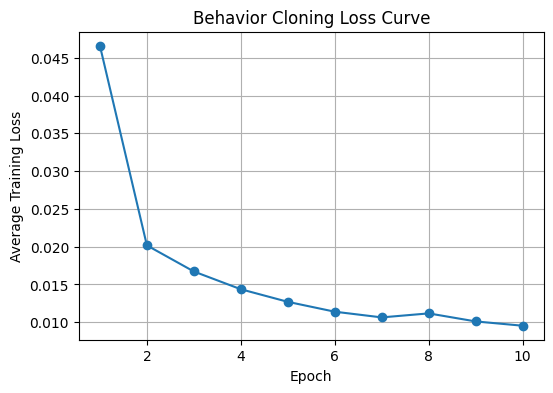

In [10]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/num_epochs — Avg Loss: {avg_loss:.6f} \n")

# plot the loss curve from initial training (behavior cloning)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Behavior Cloning Loss Curve')
plt.grid(True)
plt.show()

## DAgger Iterations

In [11]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# === DAgger Iterations using DataLoader ===

# Parameters
dagger_iterations       = 3
episodes_per_iteration  = 1
train_epochs_per_iter   = 10
batch_size              = 64

# Start from initial BC dataset
states_np  = initial_expert_states_np.copy()   # (N0, 21)
actions_np = initial_expert_actions_np.copy()  # (N0,)

for it in range(dagger_iterations):
    new_states = []
    new_actions = []

    # 1. Collect new data by rolling out current policy
    for ep in range(episodes_per_iteration):
        start = time.time()
        state = env.reset()
        for step in range(max_steps):
            # Student policy action
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_pred  = policy(state_tensor).item()

            # Record state & expert correction
            new_states.append(state)
            expert_act = expert.select_action(state, env, step)
            new_actions.append(expert_act)

            # Step environment with student action
            state, _, done, info = env.step(action_pred)
            if done:
                print(f"\nEpisode terminated: {info}")
                break
        end = time.time()
        print(f"Episode {ep+1}/{episodes_per_iteration} in DAgger Iteration {it+1}/{dagger_iterations} is done. \n Time: {end-start:.2f} seconds")


    # 2. Append new data to the NumPy arrays
    new_states_np  = np.array(new_states, dtype=np.float32)
    new_actions_np = np.array(new_actions, dtype=np.float32)
    states_np  = np.concatenate([states_np,  new_states_np], axis=0)
    actions_np = np.concatenate([actions_np, new_actions_np], axis=0)

    # 3. Rebuild dataset & loader
    states_tensor  = torch.from_numpy(states_np).float()
    actions_tensor = torch.from_numpy(actions_np).float()
    dataset = TensorDataset(states_tensor, actions_tensor)
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 4. Train on the aggregated dataset
    print(f"\n--- DAgger Iteration {it+1}/{dagger_iterations} Training ---")
    iter_losses = []
    for epoch in range(train_epochs_per_iter):
        avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
        iter_losses.append(avg_loss)
        print(f" Iter {it+1} Epoch {epoch+1}/{train_epochs_per_iter} — Avg Loss: {avg_loss:.6f}")

    # 5. Evaluate policy
    env.wind_field.disable_noise()
    # env.wind_field.enable_noise(noise_seed=100)
    avg_reward = evaluate_policy(env,
                                 policy,
                                 max_steps=max_steps,
                                 policy_name=f'DAgger_{it+1}_trained_policy_noiseless_wf',
                                 expert_avg_total_reward=expert_avg_total_reward
                                 )
    print(f" After DAgger Iter {it+1}, Avg Reward = {avg_reward:.2f}")


Episode terminated: Time limit reached
Episode 1/1 in DAgger Iteration 1/3 is done. 
 Time: 342.87 seconds

--- DAgger Iteration 1/3 Training ---
→ policy is in training mode
 Iter 1 Epoch 1/10 — Avg Loss: 0.006779
→ policy is in training mode
 Iter 1 Epoch 2/10 — Avg Loss: 0.006777
→ policy is in training mode
 Iter 1 Epoch 3/10 — Avg Loss: 0.007631
→ policy is in training mode
 Iter 1 Epoch 4/10 — Avg Loss: 0.008859
→ policy is in training mode
 Iter 1 Epoch 5/10 — Avg Loss: 0.007019
→ policy is in training mode
 Iter 1 Epoch 6/10 — Avg Loss: 0.006653
→ policy is in training mode
 Iter 1 Epoch 7/10 — Avg Loss: 0.006458
→ policy is in training mode
 Iter 1 Epoch 8/10 — Avg Loss: 0.006016
→ policy is in training mode
 Iter 1 Epoch 9/10 — Avg Loss: 0.006923
→ policy is in training mode
 Iter 1 Epoch 10/10 — Avg Loss: 0.006035
→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: -1191.76
Expert policy reward - Current policy r